# <div align="center">UPb-Plotter </div>
## <div align="center">Python code for plotting U-Pb data and exploring discordance</div>

#### <br><div align="center">Megan Mueller</div>
##### <div align="center">Please cite the accompanying article under consideration in Geochronology:</div>
<div align="center">Mueller et al., https://doi.org/10.5194/egusphere-2023-1293 </div>


# Overview 
This notebook aims to plot U-Pb data in Tera-Wasserburg space and explores discordance metrics and U-Pb uncertainty filtering.

### Initial Conditions
The code was written using file input as .xlsx file from iolite 4 output, described below, then run through Detrital-Common-Pb-Corrections. The 207Pb-corrected date and uncertainty and Pbc composition are needed (from Detrital-Common-Pb-Corrections).

### Organization
The notebook is divided into the following sections: 
1. [Data import and initial code](#Section1)
2. [Plot unfiltered uncorrected U-Pb data](#Section2)
3. [Discordance](#Section3)
4. [Exploration of data filters](#Section4)
5. [Export results](#Section5)

<a id='Section1'></a>
# 1. Import Data and Set-Up

## 1.1 Install Python Packages and Import Libraries

In [1]:
### Install Python packages
# Run to see if installed, if not, will install
# Only need to install once

import importlib
from subprocess import run

def install_if_not_installed(package_name):
    try:
        importlib.import_module(package_name)
        print(f"Package {package_name} is already installed.")
    except ImportError:
        print(f"Installing package: {package_name}")
        run(['pip', 'install', package_name], check=True)
        print(f"Installed package: {package_name}")

install_if_not_installed("pandas") # Install pandas
install_if_not_installed("numpy") # Install numpy
install_if_not_installed("matplotlib") # Install matplotlib
install_if_not_installed("tabulate") # Install tabulate
install_if_not_installed("sympy") # Install sympy
install_if_not_installed("easygui") # Install easygui
install_if_not_installed("cmcrameri") # Install cmcrameri
install_if_not_installed("intersect") # Install intersect


Package pandas is already installed.
Package numpy is already installed.
Package matplotlib is already installed.
Package tabulate is already installed.
Package sympy is already installed.
Package easygui is already installed.
Package cmcrameri is already installed.
Package intersect is already installed.


In [2]:
### Import necessary libraries

import os
import numpy as np
from cmcrameri import cm
from sympy import symbols, Eq, solve, exp
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.optimize import root
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from tabulate import tabulate
import easygui
from intersect import intersection
from scipy.spatial.distance import cdist

%matplotlib inline
%matplotlib notebook

## 1.2 Input File Organization (Data Needed to Run)
Run this section of code to load Excel spreadsheet with U-Pb data. Edit the code to specify the orrect file path, file name, and Excel sheet tab.
The following sections of code use the following data which must be present in the input file: 
- Grain ID name
- Counts per second: 206, 207, 208
- U-Pb ratios and uncertainties (1s or 2s absolute): 206/238, 238/206 and 207/206
- Error correlation (rho 207Pb/206Pb v 238U/206Pb)
- U/Th ratio
- U concentration (ppm)
- 207Pb corrected date and uncertainty (from Detrital-Common-Pb-Corrections)
- Pbc composition at corrected date (from Detrital-Common-Pb-Corrections)


In [3]:
### Load Excel file with data into DataFrame

# Specify the folder and file name
folder_path = r'C:\Users\megan\Dropbox\CommonPbPython\Example-data'  # Update this with the actual path
file_name = 'ExampleData-UPbPlotter-Muelleretal.xlsx'  # Update this with the actual file name
sheet_name = 'Sheet1'  # Update this with the actual sheet name

# Combine folder path and file name using os.path.join
excel_file_path = os.path.join(folder_path, file_name)

# Load a specific sheet into a DataFrame
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Display the DataFrame
pd.set_option('display.max_columns', None)
df.head(10) # display first 10 rows of DataFrame

,Stratigraphic Position,Analytical Run,Grain_ID,Sample_ID,InternalStd_Ti,V,± 2s abs,Cr,± 2s abs.1,Zn,± 2s abs.2,Ga,± 2s abs.3,Zr,± 2s abs.4,Nb,± 2s abs.5,Mo,± 2s abs.6,Sn,± 2s abs.7,Sb,± 2s abs.8,Hf,± 2s abs.9,Ta,± 2s abs.10,W,± 2s abs.11,logV,logCr,logZr,log(Cr/Nb),Nb/Ta,WatsonTempC,KohnTempC (eqn 13 @ 13 kbar),KohnTemp-err-neg (8 kbar),KohnTemp-err-pos (18 kbar),Cr/Nb,MaficPeliticRegion,Stratigraphic Position.1,Analytical Run.1,GrainID,Pb206_mean,Pb206_2SE(int),Pb207_mean,Pb207_2SE(int),Pb208_mean,Pb208_2SE(int),Th232_mean,Th232_2SE(int),U238_mean,U238_2SE(int),TotalBeam_mean,TotalBeam_2SE(int),BeamSeconds_mean,BeamSeconds_2SE(int),Mask_mean,Mask_2SE(int),Pb206_CPS_mean,Pb206_CPS_2SE(int),Pb207_CPS_mean,Pb207_CPS_2SE(int),Pb208_CPS_mean,Pb208_CPS_2SE(int),Th232_CPS_mean,Th232_CPS_2SE(int),U238_CPS_mean,U238_CPS_2SE(int),TotalBeam_CPS_mean,TotalBeam_CPS_2SE(int),Pb206/U238_mean,Pb206/U238_2SE(int),Pb206/U238 age_mean,Pb206/U238 age_2SE(int),Pb207/U235_mean,Pb207/U235_2SE(int),Pb207/U235 age_mean,Pb207/U235 age_2SE(int),Pb208/Th232_mean,Pb208/Th232_2SE(int),Pb208/Th232 age_mean,Pb208/Th232 age_2SE(int),DC Pb206/U238_mean,DC Pb206/U238_2SE(int),DC Pb206/U238_2SE(prop),DC Pb206/U238 age_mean,DC Pb206/U238 age_2SE(int),DC Pb207/U235_mean,DC Pb207/U235_2SE(int),DC Pb207/U235_2SE(prop),DC Pb207/U235 age_mean,DC Pb207/U235 age_2SE(int),DC Pb208/Th232_mean,DC Pb208/Th232_2SE(int),DC Pb208/Th232 age_mean,DC Pb208/Th232 age_2SE(int),DC Pb207/Pb206_mean,DC Pb207/Pb206_2SE(int),DC Pb207/Pb206_2SE(prop),DC Pb207/Pb206 age_mean,DC Pb207/Pb206 age_2SE(int),DC U238/Pb206_mean,DC U238/Pb206_2SE(int),Raw U/Th_mean,Raw U/Th_2SE(int),Final Pb206/U238_mean,Final Pb206/U238_2SE(int),Final Pb206/U238_2SE(prop),Final Pb206/U238 age_mean,Final Pb206/U238 age_2SE(int),Final Pb206/U238 age_2SE(prop),Final Pb207/U235_mean,Final Pb207/U235_2SE(int),Final Pb207/U235_2SE(prop),Final Pb207/U235 age_mean,Final Pb207/U235 age_2SE(int),Final Pb207/U235 age_2SE(prop),Final Pb207/Pb206_mean,Final Pb207/Pb206_2SE(int),Final Pb207/Pb206_2SE(prop),Final Pb207/Pb206 age_mean,Final Pb207/Pb206 age_2SE(int),Final Pb207/Pb206 age_2SE(prop),Final U238/Pb206_mean,Final U238/Pb206_2SE(int),Final U238/Pb206_2SE(prop),Final U/Th_mean,Final U/Th_2SE(int),Approx_U_PPM_mean,Approx_U_PPM_2SE(int),Approx_Th_PPM_mean,Approx_Th_PPM_2SE(int),Approx_Pb_PPM_mean,Approx_Pb_PPM_2SE(int),rho 206Pb/238U v 207Pb/235U,rho 207Pb/206Pb v 238U/206Pb,208It1_208/206c,208It1_208/206*,208It1_f206,208It1_206*/238,208It1_DateTot206,208It1_Date208c,208It1_Date208cErr,208It1_AgeDiffCorr,208It200_208/206c,208It200_208/206*,208It200_f206,208It200_206*/238,208It200_DateTot206,208It200_Date208c,208It200_Date208cErr,208It200_AgeDiffCorr,207It1_207/206c,207It1_207/206*,207It1_f206,207It1_206*/238,207It1_Date207c,207It1_Date207cErr,207It200_207/206c,207It200_207/206*,207It200_f206,207It200_206*/238,207It200_Date207c,207It200_Date207cErr
0,1,21RtA,18DMN01-01,18DMN01,59.3,1094.0,17.0,473.0,7.6,30.10,5.20,1.138,0.080,1860.00,30.00,1687.0,28.0,918.00,20.00,659.00,16.00,2.120,0.110,40.81,0.81,98.90,2.30,255.30,8.10,3.039017,2.674861,3.269513,-0.552254,17.057634,819.779402,843.879212,27.766988,27.766988,0.280379,4.0,1,21RtA,18DMN01-01,7970.522892,888.595409,4102.796894,737.745780,9981.190518,1917.601807,3668.693871,404.544370,243667.060697,9928.819991,271501.233394,11432.459771,11.487999,1.523108,1.0,0.0,7892.788241,888.595409,4065.350989,737.745780,9870.610839,1917.601807,3615.165342,404.544370,243667.060697,9928.819991,271209.287487,11432.459771,0.032521,0.003443,205.845540,21.279493,2.332548,0.426935,1137.642187,108.410788,3.108584,0.670047,25606.317028,2272.904643,0.087873,0.009441,0.010268,539.901536,54.493862,2.111567e+00,0.384769,0.402566,1072.821501,105.500347,3.110062,0.669940,25615.079442,2272.776187,0.468832,0.035398,0.035825,4072.669422,96.698219,12.567873,0.886902,72.708709,8.261398,0.034659,0.003724,0.004050,219.110349,22.942336,24.952404,2.441593,0.444906,0.465485,1168.098228,109.999912,115.087773,

### The following cell defines the input variables used in all subsequent calculations
Note that the column headings are displayed in the above cell. Change the below code if the columns are named differently. Code here uses default column headings from iolite 4 export.

Prompt asks user to input whether the input uncertainties are 1 or 2 sigma absolute. If 1s (abs), will convert to 2s (abs). The code does not handle uncertainty in percent.

*Warning: Code prompts user (bottom), will not continue without an input*

In [4]:
### Define input variables
# Everything here will be used in subsequent code
# Edit if column names are different than below. See column names in above cell output (or, run df.head(15) )

# Define variables by column headers
data_dict = df.to_dict(orient='series')

# Grain Information
GrainID = df['Grain_ID'].copy()

# Analytical Information
i386 = df['Final U238/Pb206_mean'].copy()
i386err = df['Final U238/Pb206_2SE(prop)'].copy() # 2s absolute
i76 = df['Final Pb207/Pb206_mean'].copy()
i76err = df['Final Pb207/Pb206_2SE(prop)'].copy() # 2s absolute
rho = df['rho 207Pb/206Pb v 238U/206Pb'].copy()

# Load data from 207Pb correction
# here, use 200th iteration, change column header names as needed
Date207c = df['207It200_Date207c'].copy() # Load column with final iteration 207Pb-corrected date
Date207c_err = df['207It200_Date207cErr'].copy() # Load column with final iteration 207Pb-corrected date uncertainty
finalPbc = df['207It200_207/206c'].copy() # 207/206common composition from final iteration

Date207c_err_perc = Date207c_err / Date207c * 100
df['Date207c_err_perc'] = Date207c_err_perc # Add % err to dataframe


user_input = input("\033[1mAre input file U-Pb ratio uncertainties 1-sigma absolute or 2-sigma absolute? \033[0m\n Type '1' or '2' (not 'one' or 'two') \n If 2, no calculations will be performed \n If 1, input uncertainties will be multiplied by 2 \n")
if user_input.lower() == '2':
    print("\033[1mInput uncertainties are 2s\033[0m")
elif user_input == '1':
    # Will run the following code if input uncertainties are 1s (abs) and not 2s (abs)
    i386err = df['Final U238/Pb206_2SE(prop)'].copy() * 2 # 2s absolute
    i76err = df['Final Pb207/Pb206_2SE(prop)'].copy() * 2 # 2s absolute
    print('\033[1mReminder:\033[0m Input uncertainties are 1s and were multiplied by 2. Subsequent calculations and outputs will be at 2s level')
else:
    print("\033[1mOops. Invalid input. Please enter '1' or '2'.\033[0m")

Are input file U-Pb ratio uncertainties 1-sigma absolute or 2-sigma absolute? 
 Type '1' or '2' (not 'one' or 'two') 
 If 2, no calculations will be performed 
 If 1, input uncertainties will be multiplied by 2 
2
Input uncertainties are 2s


<a id='Section2'></a>
# 2. Initial Visualization of Uncorrected U-Pb Data
The following cell plots data in Tera-Wasserburg space with 2sigma error ellipses. The code for ellipse plotting is modified from Kurt Sundell AgeCalcML_ConcordiaPlotter.m and from Drew Levy.

The cells in Section 2.1 must be run before any code following Section 2.1.

*Note that the data plotted are UNcorrected. Common Pb corrections force concordance. The below plots are UNcorrected data.*

## 2.1 Define concordia and error ellipses

The plot_concordia function is used in all subsequent sections to plot the concordia curve. The age increments are set in line: 
for age in list(range(25, 76, 25)) + list(range(100, 501, 100)) + list(range(1000, 4001, 1000)), where list(min, max, increment) in Ma/Myr.

The plot_error_ellipse function is used in all subsequent sections to plot 2s error ellipses.

In [5]:
### Define function to calculate and plot concordia curve

# Define constants
instUTh = 1; # instrument-specific U/Th, should be =1 from correction during data reduction
rat85 = 137.88; # 238U/235U ratio. 137.88 from Steiger and Jäger (1977). 137.818 from Hiess et al. (2012). 
rat58 = 0.007252683; # 1/137.88 constant 235/238 U ratio
lambda238 = 1.55125E-10; # U238 decay constant from Faure (1986)
lambda235 = 9.8485E-10; # U235 decay constant from Faure (1986)
lambda232 = 4.9475E-11; # 232Th decay constant

def plot_concordia(concordia, lambda238, lambda235, rat85):
    # Code for plotting concordia line
    # Set up time array
    t = np.linspace(1, 6000000000, 1000)  # 1000 points between 1 and 6000000000, time in yrs

    # Calculate 206/238 and 207/206 ratios over time
    X86 = 1 / (np.exp(lambda238 * t) - 1)  # 206/238 ratio over time
    Y76 = (1 / rat85) * (np.exp(lambda235 * t) - 1) / (np.exp(lambda238 * t) - 1)  # 207/206 ratio over time

    # Plot the concordia curve
    concordia.plot(X86, Y76, color='red', zorder=1)  # Plot concordia

    # Label ages at different increments
    for age in list(range(25, 76, 25)) + list(range(100, 501, 100)) + list(range(1000, 4001, 1000)):
        t = age * 1e6  # Convert age to years
        X86 = 1 / (np.exp(lambda238 * t) - 1)
        Y76 = (1 / rat85) * (np.exp(lambda235 * t) - 1) / (np.exp(lambda238 * t) - 1)

        # Plot red circle at each age increment
        concordia.plot(X86, Y76, 'or', markersize=5, zorder=2 + (age - 1) // 25)

        # Label each age increment
        concordia.text(X86 - 2, Y76 - 0.04, f'{age}', fontsize=8)


In [6]:
### Define function to calcualte and plot 2s error ellipses

def plot_error_ellipses(ax, i386, i76, i386err, i76err, data_filter = None):
    center = np.array([[i386[i], i76[i]] for i in range(len(i386))])
    center = np.where(np.all(center == 0, axis=1, keepdims=True), np.nan, center)  # replace 0.0 values with NaN

    sigx_abs = i386err
    sigy_abs = i76err
    percent_error_i386 = np.abs(sigx_abs / i386) * 100
    percent_error_i76 = np.abs(sigy_abs / i76) * 100
    Date207c_err_perc = Date207c_err / Date207c * 100
    PowerLaw = (Date207c ** -0.65) * 8 * 100
    rho_values = rho
    sigmarule = 1.25
    num_ellipse_points = 50

    elpt2s_list = []  # Initialize elpt2s outside the loop
    ellipses_list = []
    uncertainty_filter_list = []
    
    # set uncertainty_filter to be true/false based on conditions
    for i in range(len(center)):
        if data_filter == None:
            include_condition = True
        elif data_filter == "UPb_Uncertainty":
            if np.isnan(Date207c[i]):
                include_condition = False
            else:  
                include_condition = df_filters['Uncertainty_Filter'][i] == "include"
        elif data_filter == "PowerLaw":
            include_condition = df_filters['PowerLaw_Filter'][i] == "include"
        elif data_filter == "DateDepend":
            include_condition = df_filters['DateDepend_Filter'][i] == "include"
        else:
            include_condition = False  # Default to False if no valid data_filter is provided

        uncertainty_filter_list.append(include_condition)

        # Apply the mask
        if not include_condition:
            continue  # Skip this iteration if the mask is False


        # 2 sigma 2D concordia
        covmat = np.array([[sigx_abs[i]**2, rho_values[i] * sigx_abs[i] * sigy_abs[i]],
                           [rho_values[i] * sigx_abs[i] * sigy_abs[i], sigy_abs[i]**2]])

        # Check for NaN or Inf values in covmat
        if np.any(np.isnan(covmat)) or np.any(np.isinf(covmat)):
            continue  # Skip this iteration due to invalid input data

        # Check if covmat is a valid covariance matrix
        if not np.all(np.linalg.eigvals(covmat) > 0):
            continue  # Skip this iteration due to non-positive eigenvalues

        PV, PD = np.linalg.eig(covmat)
        theta = np.linspace(0, 2 * np.pi, num_ellipse_points)

        elpt2s = np.column_stack((np.cos(theta), np.sin(theta))) @ np.diag(np.sqrt(PV)) @ PD.T
        elpt2s = elpt2s * sigmarule + center[i]
        elpt2s_list.append(elpt2s)

        # Save ellipse parameters in a dictionary
        ellipse_params = {
            'center': center[i],
            'axes': np.sqrt(PV),
            'angle': np.degrees(np.arctan2(*PD[:, 0][::-1])),  # Angle in degrees
            'points': elpt2s
        }

        ellipses_list.append(ellipse_params)

        ax.plot(elpt2s[:, 0], elpt2s[:, 1], linewidth=0.5, color='black', zorder=7)  # plot error ellipses black outline

    all_points = np.concatenate(elpt2s_list)
    num_points = np.sum(~np.isnan(center[:, 0]))  # Calculate the number of non-NaN points in the center array

    return ellipses_list, all_points, num_points, uncertainty_filter_list


<a id='Section2plot'></a>
## 2.2 Plot all uncorrected U-Pb data
Plot uncorrected U-Pb data on Tera-Wasserburg diagram. Dimensions of blue box and subplot 2 can be set with x1, y1, x2, y2 below. Run the second cell below to save the figure.

This section serves as an initial visualization of all (uncorrected) U-Pb data without any filters. [Section 4](#Section4) explores various filters.

<IPython.core.display.Javascript object>


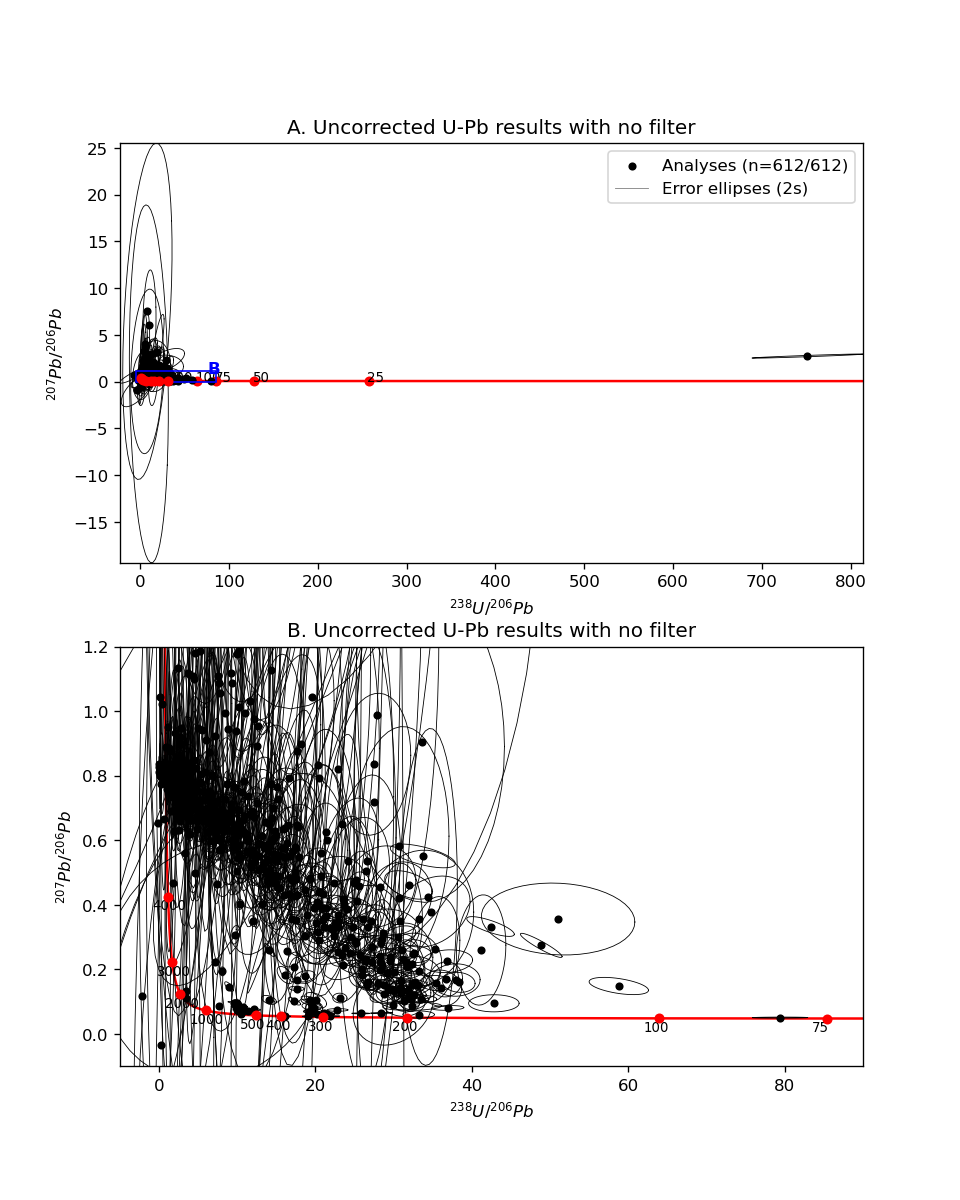

<function matplotlib.pyplot.show(*, block=None)>

In [7]:
plt.close()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

### Subplot 1: No Uncertainty threshold applied
# Plot concordia and labels
concordia = axes[0]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot error ellipses
ellipses_list, all_points, num_points, uncertainty_filter_list = plot_error_ellipses(axes[0], i386, i76, i386err, i76err, data_filter = None)
error_ellipse_legend = plt.Line2D([0], [0], color='black', linewidth=0.5, alpha=0.5, label='Error ellipses (2s)')

# Plot uncorrected U-Pb analyses
data_points = axes[0].scatter(i386, i76, color='black', label=f'Analyses (n={num_points}/{num_points})', s=15, zorder=6)



### Subplot 2: Zoom In
# Plot concordia and labels
concordia = axes[1]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot error ellipses
ellipses_list, all_points, num_points, uncertainty_filter_list = plot_error_ellipses(axes[1], i386, i76, i386err, i76err)

# Plot uncorrected U-Pb analyses
data_points = axes[1].scatter(i386, i76, color='black', label=f'Analyses (n={num_points}/{num_points})', s=15, zorder=6)



### Plot parameters for both subplots
# Set xmin, xmax, ymin, ymax to include all points
xmin, xmax = np.min(all_points[:, 0]), np.max(all_points[:, 0])
ymin, ymax = np.min(all_points[:, 1]), np.max(all_points[:, 1])
axes[0].set_xlim([xmin, xmax])
axes[0].set_ylim([ymin, ymax])

# Set axis limits for Subplot 2 to zoom on subplot 1, also sets dimensions of blue box
x1 = -5
x2 = 90
y1 = -0.1
y2 = 1.2
axes[1].set_xlim([x1, x2])
axes[1].set_ylim([y1, y2])
rectangle = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='blue', facecolor='none', zorder=8)
axes[0].add_patch(rectangle)
axes[0].text(x2, y2+1, 'B', color='blue', fontsize=10, ha='right', va='top', fontweight='bold', zorder=9)

# Add labels and legends
axes[0].legend(handles=[data_points, error_ellipse_legend])
axes[0].set_xlabel("$^{238}U/^{206}Pb$")
axes[0].set_ylabel("$^{207}Pb/^{206}Pb$")
axes[1].set_xlabel("$^{238}U/^{206}Pb$")
axes[1].set_ylabel("$^{207}Pb/^{206}Pb$")

axes[0].set_title("A. Uncorrected U-Pb results with no filter")
axes[1].set_title("B. Uncorrected U-Pb results with no filter")

plt.show


In [ ]:
### Run to save figure
# Run immediately after generating figure or might save a different figure instead
user_input = input("\033[1mDo you want to save the plot? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, "UncorrectedUPb_nofilter_v1.pdf"),
        filetypes=["*.pdf"],
        title="Select Folder and File Name to Save PDF File"
    )

    # If the user selected a file path, save the figure
    if file_path:
        fig.savefig(file_path, format="pdf")
        print("\033[1mFigure saved successfully at:\033[0m", file_path)
    else:
        print("\033[1mFigure not saved.\033[0m")
else:
    print("\033[1mFigure not saved.\033[0m")

<a id='Section3'></a>
# 3. Discordance
This section explores various metrics for calculating discordance. Common Pb corrections force concordance, so discordance calculations based on the difference in 206/238 and 207/206 dates are not applicable. This section explores two proposed discordance metrics (see Vermeesch, 2021).

#### Stacey-Kramers Distance
The Stacey-Kramers distance calculates discordance as the distance between the uncorrected analysis and the corrected analysis (on concordia), following Vermeesch (2021). To do so uses the Pbc composition calculated in the 207Pb correction.

The code uses the function 'intersection' from https://github.com/sukhbinder/intersection/tree/master based on the function written for MATLAB https://www.mathworks.com/matlabcentral/fileexchange/11837-fast-and-robust-curve-intersections. 


#### Aitchison Distance
The Aitchison distance calculates the Euclidean distance from the uncorrected analysis to the concordia curve in logarithmic space. The centered log-ratio transformation follows Eqn 4.3 in Pawlowsky-Glahn et al. (2015). See Vermeesch (2021) for further discussion.



- Pawlowsky-Glahn, V., Egozcue, J.J., Tolosana-Delgado, R., 2015. Modeling and Analysis of Compositional Data. John Wiley & Sons, Incorporated, Newark, United States.

- Vermeesch, P. (2021). On the treatment of discordant detrital zircon U–Pb data. Geochronology, 3(1), 247–257. https://doi.org/10.5194/gchron-3-247-2021


## 3.1 Stacey-Kramers distance
This section calculates discordance as the Stacey-Kramers distance. The variables used are the initial 207/206 and 238/206 ratios and 207/206 common composition from the 207Pb correction results (final iteration).

The calculation works by defining the line from the analysis to Pbc. Then the intersection function finds the intersection points between the line and concordia curve. The distance between the two intersection points is total_distance, and the distance from the analytical point to the two intersection points defines the concordance and discordance distances. The percent concordant and discordant are calculated from the total distance and lower and upper distances, respectively. Intersection points and distance are not calculated if the slope of the line from the analysis to Pbc is >= 0.

In [8]:
### Calculate discordance using distance from concordia

# Define new variables to avoid overwriting
Xs386 = i386
XsErr = i386err
Ys76 = i76
YsErr = i76err
Pbc = finalPbc # common Pb composition from concatenated 207Pb correction output  

# Calculate 206/238 and 207/206 ratios over time
t = np.linspace(1, 6000000000, 1000)  # 1000 points between 1 and 6000000000, time in yrs
X86 = 1 / (np.exp(lambda238 * t) - 1) # 206/238 ratio over time
Y76 = (1 / rat85) * (np.exp(lambda235 * t) - 1) / (np.exp(lambda238 * t) - 1) # 207/206 ratio over time

# Set up arrays
X1 = np.linspace(0, 10000000)  # change based on the youngest sample lower intercept
C = np.zeros((len(Xs386), 10))
D3 = np.zeros((len(Xs386), 10))
M1 = np.zeros((len(Xs386), 1))

# Find intersections of uncorrected analysis with concordia
for i in range(len(Xs386)):
    c = Pbc[i] # common Pb value is y-intercept
    if np.isnan(Xs386[i]) or Xs386[i] == 0: # skip if 238/206 ratio is NaN or 0.0
        C = np.array(["nan", "nan", "nan", "nan",  "nan", "nan", "nan", "nan", "nan", c])
        D3[i, :] = C
    else:
        m = (Ys76[i] - c) / Xs386[i]  # define slope of each sample point, y = mx+c
        M1[i, :] = m
    if m >= 0: # skip if slope >= 0
        C = np.array([Xs386[i], XsErr[i], Ys76[i], YsErr[i],  "nan", "nan", "nan", "nan", "nan", c])
        D3[i, :] = C
    else:
        Y1 = m * X1 + c # define line based on slope and intercept
        x, y = intersection(X86, Y76, X1, Y1) # calculate intersection points
        # Extract the x and y coordinates of the intersection points; Convert lists to numpy arrays
        x_intercept = np.array(x)
        y_intercept = np.array(y)

        if not intersection:
            C = np.array([Xs386[i], XsErr[i], Ys76[i], YsErr[i], "nan", "nan", "nan", "nan", "nan", c])
            D3[i, :] = C
        else:
            # Calculate age at intercept
            t68_1 = np.nan if len(x_intercept) < 1 else np.log((1. / x_intercept[0]) + 1) / lambda238  # 206/238 date in yrs
            t68M_1 = np.nan if np.isnan(t68_1) else t68_1 / 1000000  # 206/238 date in Myrs
            t68_2 = np.nan if len(x_intercept) < 2 else np.log((1. / x_intercept[1]) + 1) / lambda238  # 206/238 date in yrs
            t68M_2 = np.nan if np.isnan(t68_2) else t68_2 / 1000000  # 206/238 date in Myrs

            C = np.array([Xs386[i], XsErr[i], Ys76[i], YsErr[i],
                          x_intercept[0] if len(x_intercept) > 0 else np.nan,
                          y_intercept[0] if len(y_intercept) > 0 else np.nan,
                          x_intercept[1] if len(x_intercept) > 1 else np.nan,
                          y_intercept[1] if len(y_intercept) > 1 else np.nan,
                          m, #t68M_1, t68M_2, 
                          c])
            D3[i, :] = C
                

# Save results into new DataFrame                
df_Discordance = pd.DataFrame(
    D3, 
    columns=["238/206measured", "238/206m_err", "207/206measured", "207/206m_err",
           "Intersect1_X1", "Intersect1_Y1", "Intersect2_X2", "Intersect2_Y2",
           "Slope (m)", "207/206c"]
)


# Calculate discordance as distance along discordia
df_Discordance['SK_total_distance'] = np.sqrt((df_Discordance['Intersect2_X2'] - df_Discordance['Intersect1_X1'])**2 + (df_Discordance['Intersect2_Y2'] - df_Discordance['Intersect1_Y1'])**2)
df_Discordance['SK_upper_distance'] = np.sqrt((df_Discordance['Intersect2_X2'] - df_Discordance['238/206measured'])**2 + (df_Discordance['Intersect2_Y2'] - df_Discordance['207/206measured'])**2)
df_Discordance['SK_lower_distance'] = np.sqrt((df_Discordance['238/206measured'] - df_Discordance['Intersect1_X1'])**2 + (df_Discordance['207/206measured'] - df_Discordance['Intersect1_Y1'])**2)
df_Discordance['SK_percent_discordant'] = df_Discordance['SK_lower_distance'] / df_Discordance['SK_total_distance'] * 100
df_Discordance['SK_percent_concordant'] = df_Discordance['SK_upper_distance'] / df_Discordance['SK_total_distance'] * 100

print(df_Discordance)

     238/206measured  238/206m_err  207/206measured  207/206m_err  \
0          31.924068      2.450234         0.461403      0.035258   
1          48.871312      2.134690         0.274198      0.029860   
2          58.788514      3.037964         0.148284      0.021373   
3          42.390934      2.431439         0.332592      0.024476   
4                NaN           NaN              NaN           NaN   
..               ...           ...              ...           ...   
926         3.847106      0.486163         0.792532      0.032510   
927         3.370032      0.196413         0.745751      0.024604   
928         8.552983      0.955677         0.655113      0.073139   
929        30.652675      3.380052         0.420317      0.090112   
930         1.251574      0.240959         0.799255      0.089902   

     Intersect1_X1  Intersect1_Y1  Intersect2_X2  Intersect2_Y2  Slope (m)  \
0        66.559955       0.047936       0.858715       0.832247  -0.011938   
1        68.313


### Visualize the results
Display the results of the Stacey-Kramers discordance calculation. Subplots 1-4 displays all uncorrected U-Pb anayses, intersection points, and intersection lines. Subplots 2-4 color the U-Pb analysis circles by various Stacey-Kramers results values. No data filter is applied. 

It may take a moment for the plot to populate.

Note: adjust the x- and y-axis limits as needed. Adjust vmin and vmax to the desired min/max of colorbar in subplots 2-4, likely close to the x-axis limits of interest.

Generating plot. Please be patient...


<IPython.core.display.Javascript object>


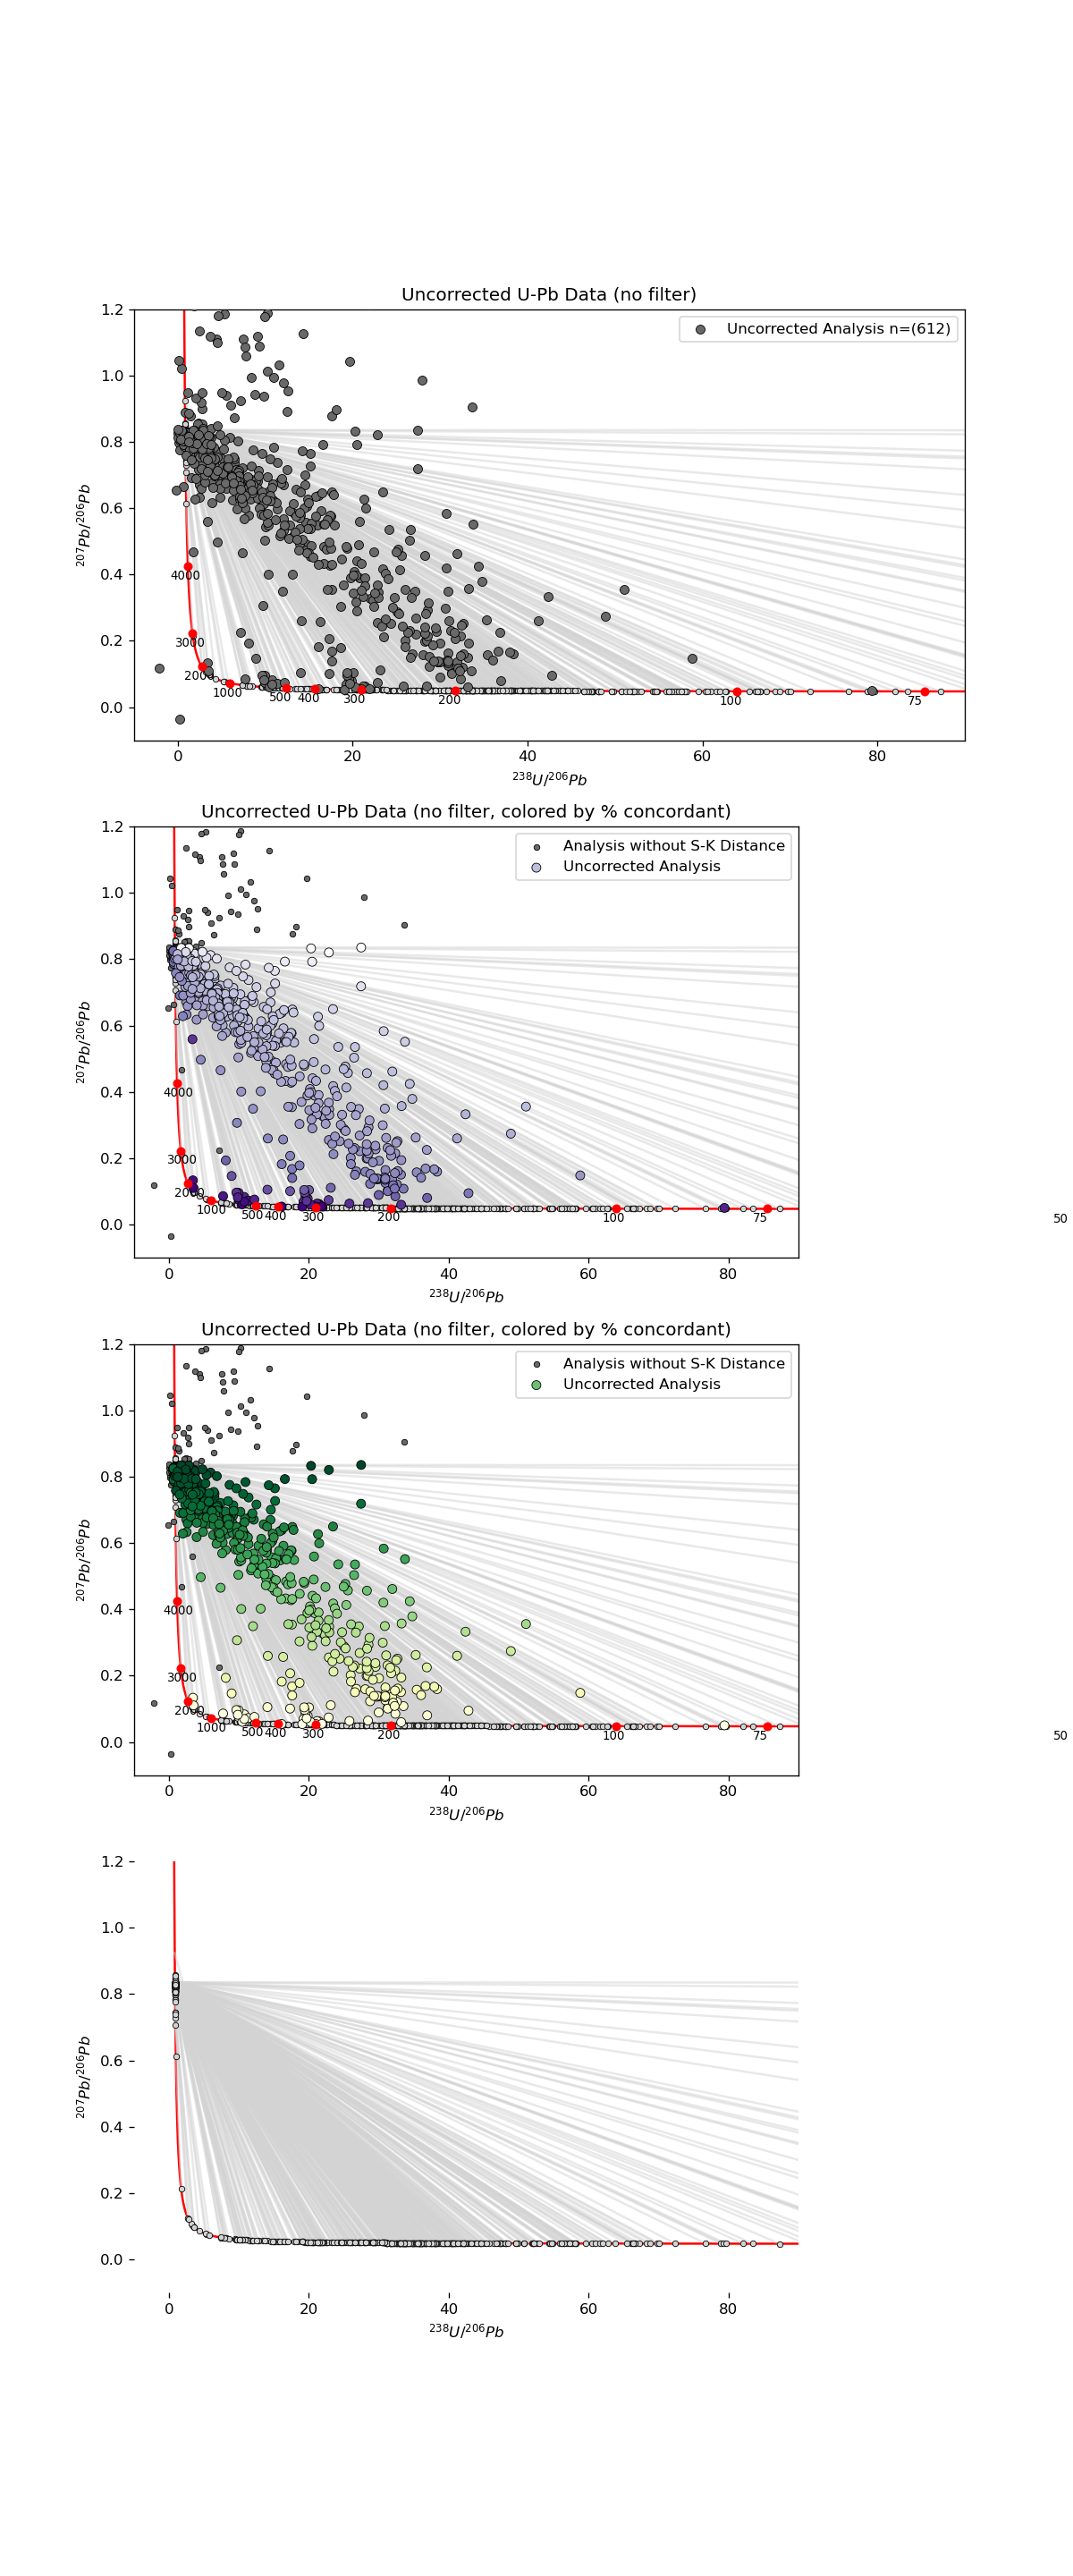

In [12]:
### Plot results of Stacey-Kramers discordance
# gray lines and gray points are the intersection lines and points, respectively

# uncorrected analysis points
num_rows = len(i386)
Xs386_data = i386[:num_rows] 
Ys76_data = i76[:num_rows]
percConc = df_Discordance['SK_percent_concordant'][:num_rows]
SKdist = df_Discordance['SK_lower_distance'][:num_rows]

# intersection points
# Extract x, y data for the first 4 rows
x1_data = D3[:num_rows, 4] 
y1_data = D3[:num_rows, 5]
x2_data = D3[:num_rows, 6]
y2_data = D3[:num_rows, 7]

# 207 correction points
Pbc_y = Pbc # common Pb composition from concatenated 207Pb correction output 
Pbc_x = np.full(len(Pbc_y), 0)

# Mask analytical points where 238/206 or 207/206 = 0
zero_mask = (i386 == 0) | (i76 == 0) | np.isnan(i386) | np.isnan(i76) # number NaN or 0 values

print("Generating plot. Please be patient...")
plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 24))

### Subplot 1
#Plot concordia and labels
concordia = axes[0]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot the points and connect them with lines
axes[0].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], color='dimgray', edgecolors='black', linewidths=0.5, 
                label=f'Uncorrected Analysis n=({np.sum(~zero_mask)})', zorder=3)

# Plot intersection lines
for i in range(len(x1_data)):
    #color = plt.cm.RdPu_r(i / len(x1_data+2))
    axes[0].scatter(x1_data[i], y1_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[0].scatter(x2_data[i], y2_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[0].plot([x1_data[i], x2_data[i]], [y1_data[i], y2_data[i]], zorder=1, color='lightgray', alpha=0.5)

# Add labels and title
axes[0].set_xlabel('$^{238}U/^{206}Pb$')
axes[0].set_ylabel('$^{207}Pb/^{206}Pb$')
axes[0].set_title('Uncorrected U-Pb Data (no filter)')
axes[0].set_ylim(-0.1, 1.2)
axes[0].set_xlim(-5, 90)
axes[0].legend()


### Subplot 2 - colored by Stacey-Kramers distance
#Plot concordia and labels
concordia = axes[1]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot the points and connect them with lines
axes[1].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], color='dimgray', edgecolors='black', linewidths=0.5, 
                label=f'Analysis without S-K Distance', s=15, zorder=3)
scatter_plot = axes[1].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], c=SKdist[~zero_mask], cmap='Purples_r',
                               norm=mcolors.LogNorm(vmin=0.1, vmax=1000),
                               edgecolors='black', linewidths=0.5,
                label=f'Uncorrected Analysis', zorder=4)

# Plot intersection lines
for i in range(len(x1_data)):
    #color = plt.cm.PuRd_r(i / len(x1_data+2))
    axes[1].scatter(x1_data[i], y1_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[1].scatter(x2_data[i], y2_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[1].plot([x1_data[i], x2_data[i]], [y1_data[i], y2_data[i]], zorder=1, color='lightgray', alpha=0.5)

# Add labels and title
axes[1].set_xlabel('$^{238}U/^{206}Pb$')
axes[1].set_ylabel('$^{207}Pb/^{206}Pb$')
axes[1].set_title('Uncorrected U-Pb Data (no filter, colored by % concordant)')
axes[1].set_ylim(-0.1, 1.2)
axes[1].set_xlim(-5, 90)
axes[1].legend()
colorbar = plt.colorbar(scatter_plot, ax=axes[1], label='Stacey-Kramers Distance')


# Subplot 3 - colored by percent concordant
#Plot concordia and labels
concordia = axes[2]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot the points and connect them with lines
axes[2].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], color='dimgray', edgecolors='black', linewidths=0.5, 
                label=f'Analysis without S-K Distance', s=15, zorder=3)
scatter_plot = axes[2].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], c=percConc[~zero_mask], cmap='YlGn_r', 
                vmin=0, vmax=100, edgecolors='black', linewidths=0.5,
                label=f'Uncorrected Analysis', zorder=4)

# Plot intersection lines
for i in range(len(x1_data)):
    axes[2].scatter(x1_data[i], y1_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[2].scatter(x2_data[i], y2_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[2].plot([x1_data[i], x2_data[i]], [y1_data[i], y2_data[i]], zorder=1, color='lightgray', alpha=0.5)

# Add labels and title
axes[2].set_xlabel('$^{238}U/^{206}Pb$')
axes[2].set_ylabel('$^{207}Pb/^{206}Pb$')
axes[2].set_title('Uncorrected U-Pb Data (no filter, colored by % concordant)')
axes[2].set_ylim(-0.1, 1.2)
axes[2].set_xlim(-5, 90)
axes[2].legend()
colorbar = plt.colorbar(scatter_plot, ax=axes[2], label='Concordance (%)')



# Subplot 4 - colored by lower intersection
#Plot concordia and labels
concordia = axes[3]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot the points and connect them with lines
axes[3].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], color='dimgray', edgecolors='black', linewidths=0.5, 
                label=f'Analysis without S-K Distance', s=15, zorder=3)
scatter_plot = axes[3].scatter(Xs386_data[~zero_mask], Ys76_data[~zero_mask], c=x1_data[~zero_mask], cmap='Blues_r', 
                vmin=0, vmax=100, edgecolors='black', linewidths=0.5, 
                label=f'Uncorrected Analysis (n={np.count_nonzero(~zero_mask)}/{np.sum(~zero_mask)})', zorder=3)

# Plot intersection lines
for i in range(len(x1_data)):
    axes[3].scatter(x1_data[i], y1_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[3].scatter(x2_data[i], y2_data[i], s=15, color='lightgray', edgecolors='black', linewidths=0.5, zorder=2)
    axes[3].plot([x1_data[i], x2_data[i]], [y1_data[i], y2_data[i]], zorder=1, color='lightgray', alpha=0.5)


axes[3].set_xlabel('$^{238}U/^{206}Pb$')
axes[3].set_ylabel('$^{207}Pb/^{206}Pb$')
axes[3].set_title('Uncorrected U-Pb Data (no filter, colored by lower intersection)')
axes[3].set_ylim(-0.1, 1.2)
axes[3].set_xlim(-5, 90)
axes[3].legend()
colorbar = plt.colorbar(scatter_plot, ax=axes[3], label='Lower Intersection (in $^{238}U/^{206}Pb$)')


plt.show()

In [ ]:
### Run to save figure
# Run immediately after generating figure or might save a different figure instead
user_input = input("\033[1mDo you want to save the plot? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n Please be patient as figure saves... \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, "Discordance_SKdistance_v1.pdf"),
        filetypes=["*.pdf"],
        title="Select Folder and File Name to Save PDF File"
    )

    # If the user selected a file path, save the figure
    if file_path:
        fig.savefig(file_path, format="pdf")
        print("\033[1mFigure saved successfully at:\033[0m", file_path)
    else:
        print("\033[1mFigure not saved.\033[0m")
else:
    print("\033[1mFigure not saved.\033[0m")

## 3.2 Aitchison distance
Calculate the Aitchison distance then plot the results.

Centered log-ratio transformation (see Eqn 4.3 in Pawlowsky-Glahn et al., 2015):
1. Create a vector representing the geometric mean for each row of the compositional data: np.geomspace(1, 1, UPb_data.shape[1])
2. Normalize data by element-wise division of each row in UPb_data by the corresponding geometric mean
3. Take natural log of ratios
4. Resulting log_ratio_UPb_data array contains the log-ratio-transformed compositional data

- Pawlowsky-Glahn, V., Egozcue, J.J., Tolosana-Delgado, R., 2015. Modeling and Analysis of Compositional Data. John Wiley & Sons, Incorporated, Newark, United States.


In [17]:
### Calculate Aitchison distance

# Initial variables
Xs386 = i386
XsErr = i386err
Ys76 = i76
YsErr = i76err

# Set up concordia curve time array
t = np.linspace(1, 6000e6, 1000)  # 1000 points between 1 and 6000000000, time in yrs
X86 = 1 / (np.exp(lambda238 * t) - 1) # 206/238 ratio over time
Y76 = (1 / rat85) * (np.exp(lambda235 * t) - 1) / (np.exp(lambda238 * t) - 1) # 207/206 ratio over time

# Mark some points along the concordia at specified times
tMyr = np.array([75e6, 100e6, 200e6, 350e6, 500e6, 750e6, 1000e6, 2000e6, 3000e6, 4000e6])
X86tMyr = 1 / (np.exp(lambda238 * tMyr) - 1) # 206/238 ratio at specified time
Y76tMyr = (1 / rat85) * (np.exp(lambda235 * tMyr) - 1) / (np.exp(lambda238 * tMyr) - 1) # 207/206 ratio at specified time
age = tMyr / 1e6

# U-Pb data and concordia curve
UPb_data = np.column_stack((Xs386, Ys76))
curve_data = np.column_stack((X86, Y76))

# Replace negative or 0.0 values with NaN
UPb_data = np.where((UPb_data == 0.0) | (UPb_data < 0.0), np.nan, UPb_data)
curve_data = np.where((curve_data == 0.0) | (curve_data < 0.0), np.nan, curve_data)

# Centered log-ratio transformation
log_ratio_UPb_data = np.log(UPb_data / np.geomspace(1, 1, UPb_data.shape[1]))
log_ratio_curve_data = np.log(curve_data / np.geomspace(1, 1, curve_data.shape[1]))

# Calculate Aitchison distances
aitchison_distances = cdist(log_ratio_UPb_data, log_ratio_curve_data, metric='euclidean')

# Find the minimum distances
aitchison_distances_min = np.min(aitchison_distances, axis=1)
df_Discordance['Aitchison_distance'] = aitchison_distances_min

# Print the results
print("Aitchison Distances (Distance from U-Pb analysis to every pt of concordia curve, 1000 distances per analysis):")
print(aitchison_distances[:5])

print("\n\nMinimum Aitchison Distance:")
print(aitchison_distances_min[:15])

Aitchison Distances (Distance from U-Pb analysis to every pt of concordia curve, 1000 distances per analysis):
[[19.26179997  4.20154295  3.63962944 ...  4.10607879  4.10894556
   4.11181498]
 [18.78253601  3.56589772  2.98377054 ...  4.68974985  4.6928868
   4.69602573]
 [18.54974639  3.12981434  2.4984725  ...  5.12418551  5.12763866
   5.13109329]
 [18.94333149  3.78681115  3.21385964 ...  4.48493308  4.48797547
   4.49102005]
 [        nan         nan         nan ...         nan         nan
          nan]]


Minimum Aitchison Distance:
[2.21078718 1.7264962  1.12270168 1.90967442        nan        nan
 0.95569428 2.63298876 1.41168905        nan        nan 2.21358113
        nan        nan        nan]


### Visualize the results
Display the results of the Aitchison distance discordance calculation. All points are uncorrected U-Pb analyses. The U-Pb analyses are colored by Aitchison distance in both plots. No filter is applied to the U-Pb data.

Note: This section does not use the concordia function. Update 'tMyr' to determine which ages are labeled on concordia curve. Modify 't_isochron' variable to set the date of the isochron plotted on both subplots.Adjust 't_isochron' to change which isochron date is plotted. 

<IPython.core.display.Javascript object>


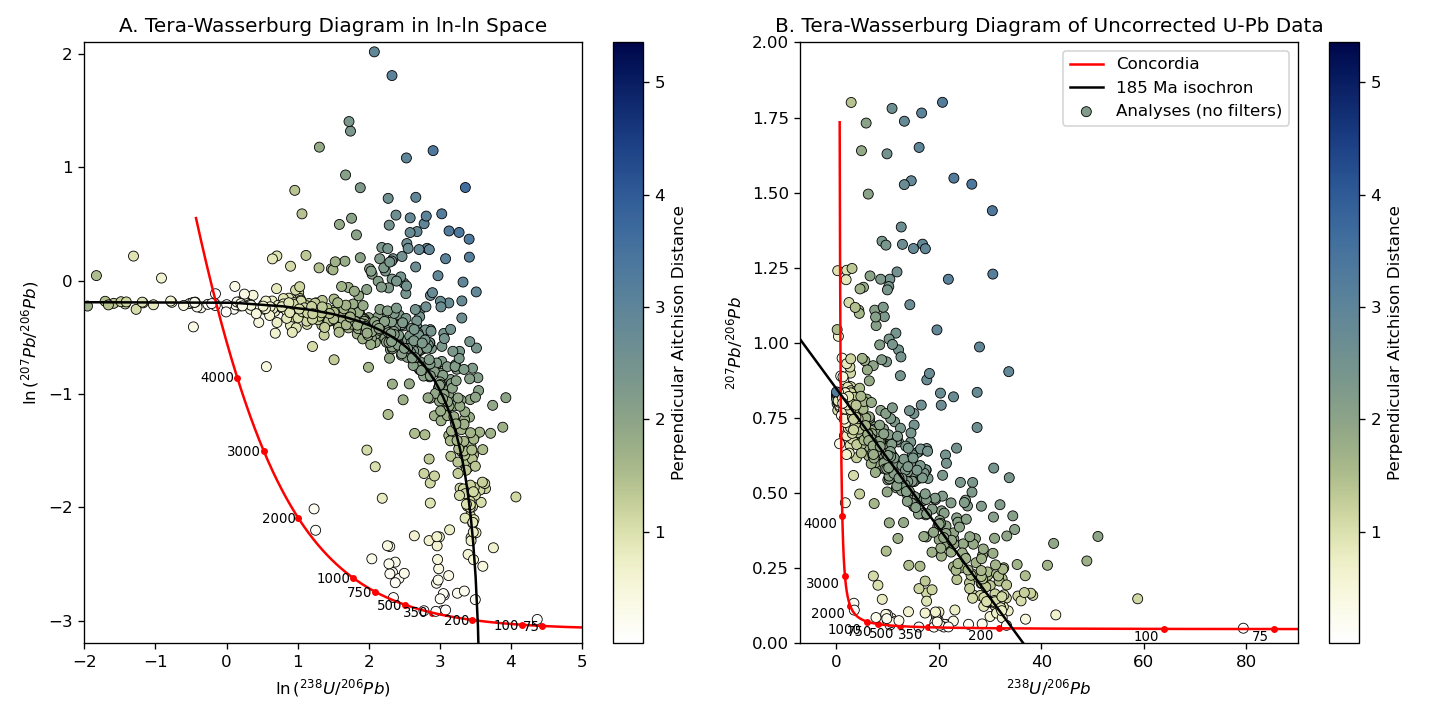

C:\Users\megan\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
### Plot Aitchison distance


# calculate discordia line at 185 Ma
t_isochron = 185e6 # date in yrs
X2_line = 1 / (np.exp(lambda238 * t_isochron) - 1)
Y2_line = (1 / rat85) * (np.exp(lambda235 * t_isochron) - 1) / (np.exp(lambda238 * t_isochron) - 1)
X1_line = 1e-10
a64 = 9.74 * (np.exp((lambda238 * 3.7E9)) - np.exp((lambda238 * t_isochron))) + 11.152 # 206/204 common ratio from estimated dates younger than 3.7 Ga using Stacey-Kramers eqn. and initial 206/238 Age estimate
a74 = (9.74 / rat85) * (np.exp((lambda235 * 3.7E9)) - np.exp((lambda235 * t_isochron))) + 12.998 # 207/204 common ratio from estimated dates younger than 3.7 Ga using Stacey-Kramers eqn. and initial 206/238 Age estimate
Y1_line = a74 / a64
slope = (Y2_line - Y1_line) / (X2_line - X1_line)
b = Y1_line - slope * X1_line
x_values = np.linspace(-10, 100, 100)
y_values = slope * x_values + b

# Avoid zero or negative y_values by clipping to a small positive value
x_values_clip = np.clip(x_values, a_min=1e-6, a_max=None)
y_values_clip = np.clip(y_values, a_min=1e-6, a_max=None)  
ln_x_values = np.log(x_values_clip)
ln_y_values = np.log(y_values_clip)



# Plot
plt.close()
plt.figure(figsize=(12,6))
cmap = cm.davos_r # set colormap

### Subplot 1
plt.subplot(1, 2, 1)
plt.plot(np.log(X86), np.log(Y76), label='Concordia', color='red')
plt.scatter(np.log(X86tMyr), np.log(Y76tMyr), color='red', s=10)  # Mark specified points in red
plt.plot(ln_x_values, ln_y_values, label='185 Ma isochron', color='black') # label=f'ln(y) = {slope:.2f}ln(x) + {np.log(np.abs(b)):.2f}'
scatter2 = plt.scatter(np.log(Xs386), np.log(Ys76), c=aitchison_distances_min, cmap=cmap, label='Analyses',  edgecolors='black', linewidth=0.5)  # Scatter plot of data in black

plt.xlim(-2,5) # adjust as needed
plt.ylim(-3.2, 2.1) # adjust as needed
plt.xlabel(r'$\ln\left({^{238}U}/{^{206}Pb}\right)$')
plt.ylabel(r'$\ln\left({^{207}Pb}/{^{206}Pb}\right)$')
plt.title('A. Tera-Wasserburg Diagram in ln-ln Space')
#plt.legend()
cbar = plt.colorbar(scatter2, label='Perpendicular Aitchison Distance')

# Add text labels for specified points on concordia
for i, age in enumerate(tMyr / 1e6):
    plt.text(np.log(X86tMyr[i])-0.04, np.log(Y76tMyr[i]) -0.07, f'{age:.0f}', fontsize=8, color='black', ha='right', va='bottom')


### Subplot 2
plt.subplot(1, 2, 2)
plt.plot(X86, Y76, label='Concordia', color='red')
plt.scatter(X86tMyr, Y76tMyr, color='red', s=10)  # Mark specified points in red
plt.plot(x_values, y_values, label='185 Ma isochron', color='black') # label = f'y = {slope:.2f}x + {b:.2f}'
scatter1 = plt.scatter(Xs386, Ys76, c=aitchison_distances_min, cmap=cmap, label='Analyses (no filters)', 
                       edgecolors='black', linewidth=0.5)
plt.xlabel('$^{238}U/^{206}Pb$')
plt.ylabel('$^{207}Pb/^{206}Pb$')
plt.title('B. Tera-Wasserburg Diagram of Uncorrected U-Pb Data')
plt.xlim(-7, 90) # adjust as needed
plt.ylim(0, 2) # adjust as needed
plt.legend()

# Add colorbar
cbar = plt.colorbar(scatter1, label='Perpendicular Aitchison Distance')

# Add text labels for specified points on concordia
for i, age in enumerate(tMyr / 1e6):
    plt.text(X86tMyr[i] -1, Y76tMyr[i] -0.05, f'{age:.0f}', fontsize=8, color='black', ha='right', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
### Run to save figure
# Run immediately after generating figure or might save a different figure instead
user_input = input("\033[1mDo you want to save the plot? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, "Discordance_AitchisonDistance_v1.pdf"),
        filetypes=["*.pdf"],
        title="Select Folder and File Name to Save PDF File"
    )

    # If the user selected a file path, save the figure
    if file_path:
        plt.savefig(file_path, format="pdf")
        print("\033[1mFigure saved successfully at:\033[0m", file_path)
    else:
        print("\033[1mFigure not saved.\033[0m")
else:
    print("\033[1mFigure not saved.\033[0m")

<a id='Section4'></a>
# 4. Explore U-Pb Filters

The following section includes Tera-Wasserburg diagrams of uncorrected U-Pb data to explore various filters. All data points (unfiltered) are plotted in [Section 2](#Section2plot).

#### Explore effects of filtering by applying an uncertainty threshold:
- Only points < 20% uncertainty on 238/206 *and* 207/206 ratios (modified from Lippert, 2014)
- Date-dependent uncertainty windows (following Govin et al., 2018, Geology)
    * 207Pb-corrected date > 100 Ma, uncertainty > 10 %
    * 207Pb-corrected date 10-100 Ma, uncertainty > 20 %
    * 207Pb-corrected date < 10 Ma, uncertainty > 25 %
- Power law uncertainty filter (following Chew et al., 2020, Earth Sci. Rev.)
    * 207Pb corrected date uncertainty (2s %) =  8 x (date ^ -0.65)


Note that the U-Pb data plotted are UNcorrected. Common Pb corrections force concordance. The below plots are UNcorrected data. Adjust axis limits as needed.

- Chew, D., O’Sullivan, G., Caracciolo, L., Mark, C., Tyrrell, S., 2020. Sourcing the sand: Accessory mineral fertility, analytical and other biases in detrital U-Pb provenance analysis. Earth-Science Reviews 202, 103093. https://doi.org/10.1016/j.earscirev.2020.103093

- Govin, G., Najman, Y., Copley, A., Millar, I., van der Beek, P., Huyghe, P., Grujic, D., Davenport, J., 2018. Timing and mechanism of the rise of the Shillong Plateau in the Himalayan foreland. Geology 46, 279–282. https://doi.org/10.1130/G39864.1

- Lippert, P.G., 2014. Detrital U-Pb geochronology provenance analyses: case studies in the Greater Green River Basin, Wyoming, and the Book Cliffs, Utah (Thesis). University of Kansas.


In [ ]:
### Define which analyses to include/exclude based on filters

# Variables
Xs386 = i386
XsErr = i386err
Ys76 = i76
YsErr = i76err
XsErrPerc = abs(XsErr / Xs386 * 100) # use absolute values to exclude negatives
YsErrPerc = abs(YsErr / Ys76 * 100)

power_law = (Date207c ** -0.65) * 8 * 100

# Create a condition based on the variables
threshold = 20 # threshold to use for U-Pb ratio uncertainty (i.e., 20%)
UPb_PercErr_filter = np.where((XsErrPerc < threshold) & (YsErrPerc < threshold), 'include', 'exclude')

power_law_filter = np.where((Date207c_err_perc < power_law), 'include', 'exclude')

# Add to new dataframe
df_filters = pd.DataFrame({'238/206_Err(%)': XsErrPerc, '207/206_Err(%)': YsErrPerc, 'Uncertainty_Filter': UPb_PercErr_filter, 'PowerLaw_Filter': power_law_filter})

# Date-dependent filter conditions
condition_1 = (Date207c_err_perc > 10) & (Date207c > 100)
condition_2 = ((Date207c_err_perc > 20) & (Date207c > 10) & (Date207c <= 100))
condition_3 = (Date207c_err_perc > 25) & (Date207c <= 10)
condition_4 = (Date207c == 0.0) | pd.isnull(Date207c)

# Add to dataframe
df_filters['DateDepend_Filter'] = np.where(condition_1 | condition_2 | condition_3 | condition_4, 'exclude', 'include')

# Print the result DataFrame
print(df_filters.head(20))


In [ ]:
plt.close()

print("Generating plot. Please be patient...")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12)) # figsize(width,height)
plt.subplots_adjust(wspace=0.25, hspace=0.25) # adjust spacing between subplots


### Subplot 1: Only points < 20% uncertainty on 207/206 and 238/206 ratios (set uncertainty threshold % in cell above; modified from Lippert, 2014)

# Plot concordia and labels
concordia = axes[0]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot error ellipses
ellipses_list, all_points, num_points, uncertainty_filter_list = plot_error_ellipses(axes[0], i386, i76, i386err, i76err, 
                                                                                 data_filter = 'UPb_Uncertainty')
error_ellipse_legend = plt.Line2D([0], [0], color='black', linewidth=0.5, alpha=0.5, label='Error ellipses (2s)')

# Plot uncorrected U-Pb analyses
uncertainty_filter = np.array(uncertainty_filter_list)
num_analyses_included = np.count_nonzero(uncertainty_filter)
data_points = axes[0].scatter(i386[uncertainty_filter], i76[uncertainty_filter], color='black', 
                              label=f'Analyses (n={num_analyses_included}/{num_points})', s=5, zorder=6)




### Subplot 2: Following date-dependent filter on age uncertainty from Govin et al., 2018

# Plot concordia and labels
concordia = axes[1]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot error ellipses
ellipses_list, all_points, num_points, uncertainty_filter_list = plot_error_ellipses(axes[1], i386, i76, i386err, i76err, 
                                                                                     data_filter = 'DateDepend')
error_ellipse_legend = plt.Line2D([0], [0], color='black', linewidth=0.5, alpha=0.5, label='Error ellipses (2s)')

# Plot uncorrected U-Pb analyses
uncertainty_filter = np.array(uncertainty_filter_list)
num_analyses_included = np.count_nonzero(uncertainty_filter)
data_points = axes[1].scatter(i386[uncertainty_filter], i76[uncertainty_filter], color='black', 
                              label=f'Analyses (n={num_analyses_included}/{num_points})', s=5, zorder=6)



### Subplot 3: Following power law filter on age uncertainty from Chew et al., 2020

# Plot concordia and labels
concordia = axes[2]
plot_concordia(concordia, lambda238, lambda235, rat85)

# Plot error ellipses
ellipses_list, all_points, num_points, uncertainty_filter_list = plot_error_ellipses(axes[2], i386, i76, i386err, i76err, 
                                                                                     data_filter = "PowerLaw")
error_ellipse_legend = plt.Line2D([0], [0], color='black', linewidth=0.5, alpha=0.5, label='Error ellipses (2s)')

# Plot uncorrected U-Pb analyses
uncertainty_filter = np.array(uncertainty_filter_list)
num_analyses_included = np.count_nonzero(uncertainty_filter)
data_points = axes[2].scatter(i386[uncertainty_filter], i76[uncertainty_filter], color='black', 
                              label=f'Analyses (n={num_analyses_included}/{num_points})', s=5, zorder=6)

# Add included/excluded to DataFrame
# Change header as needed
df['PowerLaw (Chew2020)'] = np.where(uncertainty_filter, 'include', 'exclude')


## Plot parameters for all subplots

# Set axis limits for Subplot 2 to zoom on subplot 1, also sets dimensions of blue box
# caluclate min, max to include all points
xmin, xmax = np.min(all_points[:, 0]), np.max(all_points[:, 0])
ymin, ymax = np.min(all_points[:, 1]), np.max(all_points[:, 1])

# set axis limits for all subplots
# can use xmin, xmax, ymin, ymax or manually-set values
axes[0].set_xlim([xmin, xmax])
axes[0].set_ylim([ymin, ymax])
axes[0].set_xlim([-5, 90])
axes[0].set_ylim([-0.1, 1.2])
#axes[1].set_xlim([xmin,xmax])
#axes[1].set_ylim([ymin, ymax])
axes[1].set_xlim([-5, 90])
axes[1].set_ylim([-0.1, 1.2])
#axes[0].set_xlim([xmin, xmax])
#axes[0].set_ylim([ymin, ymax])
axes[0].set_xlim([-5, 90])
axes[0].set_ylim([-0.1, 1.2])
axes[1].set_xlim([-5, 90])
axes[1].set_ylim([-0.1, 1.2])
axes[2].set_xlim([-5, 90])
axes[2].set_ylim([-0.1, 1.2])


# Add labels and legends
axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_xlabel("$^{238}U/^{206}Pb$")
axes[0].set_ylabel("$^{207}Pb/^{206}Pb$")
axes[1].set_xlabel("$^{238}U/^{206}Pb$")
axes[1].set_ylabel("$^{207}Pb/^{206}Pb$")
axes[2].set_xlabel("$^{238}U/^{206}Pb$")
axes[2].set_ylabel("$^{207}Pb/^{206}Pb$")

axes[0].set_title(f"A. Uncorrected U-Pb results with 238/206 and 207/206 uncertainty filter ({threshold}%)")
axes[1].set_title("B. Uncorrected U-Pb results with 207Pbc date-dependent filter (Govin et al 2018)")
axes[2].set_title("C. Uncorrected U-Pb results with power law filter (Chew et al 2020)")

plt.show


In [ ]:
### Run to save figure
# Run immediately after generating figure or might save a different figure instead
user_input = input("\033[1mDo you want to save the plot? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n Please be patient as figure saves... \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, "UPb_UncertaintyFilters_v1.pdf"),
        filetypes=["*.pdf"],
        title="Select Folder and File Name to Save PDF File"
    )

    # If the user selected a file path, save the figure
    if file_path:
        fig.savefig(file_path, format="pdf")
        print("\033[1mFigure saved successfully at:\033[0m", file_path)
    else:
        print("\033[1mFigure not saved.\033[0m")
else:
    print("\033[1mFigure not saved.\033[0m")

<a id='Section5'></a>
# 5. View and Export Results

In [ ]:
# Run to concatenate DataFrames horizontally
result_df = pd.concat([df, df_Discordance, df_filters], axis=1)

# Display the result
result_df.head(15)

In [ ]:
### Export the DataFrame to Excel
# do not run without running above cell to concatenate dataframes

user_input = input("\033[1mDo you want to save to Excel? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, "OutputFile_UPbPlotter_v1.xlsx"),
        filetypes=["*.xlsx"],
        title="Select Folder and File Name to Save Excel File"
    )

    # If the user selected a file path, save the DataFrame to Excel
    if file_path:
        result_df.to_excel(file_path, index=False)
        print("\033[1mDataFrame saved to Excel:\033[0m", file_path)
    else:
        print("\033[1mDataFrame not saved.\033[0m")
else:
    print("\033[1mDataFrame not saved.\033[0m")


# Display the concatenated DataFrame 
#pd.set_option('display.max_columns', None)
#print('\n\n\033[1mConcatenated DataFrame:')
#result_df.head(15)